In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as sts
from matplotlib import cm
from scipy.interpolate import interp1d
from scipy import signal
import dataframe_image


In [243]:
data = pd.read_csv("data.csv")
data.head()

,theta,N,errorN
0,0,866,20
1,15,791,20
2,30,701,20
3,40,647,20
4,50,592,20


In [244]:
def interpolation_func(theta, A):
    return A * (1 - np.cos(theta * np.pi / 180))

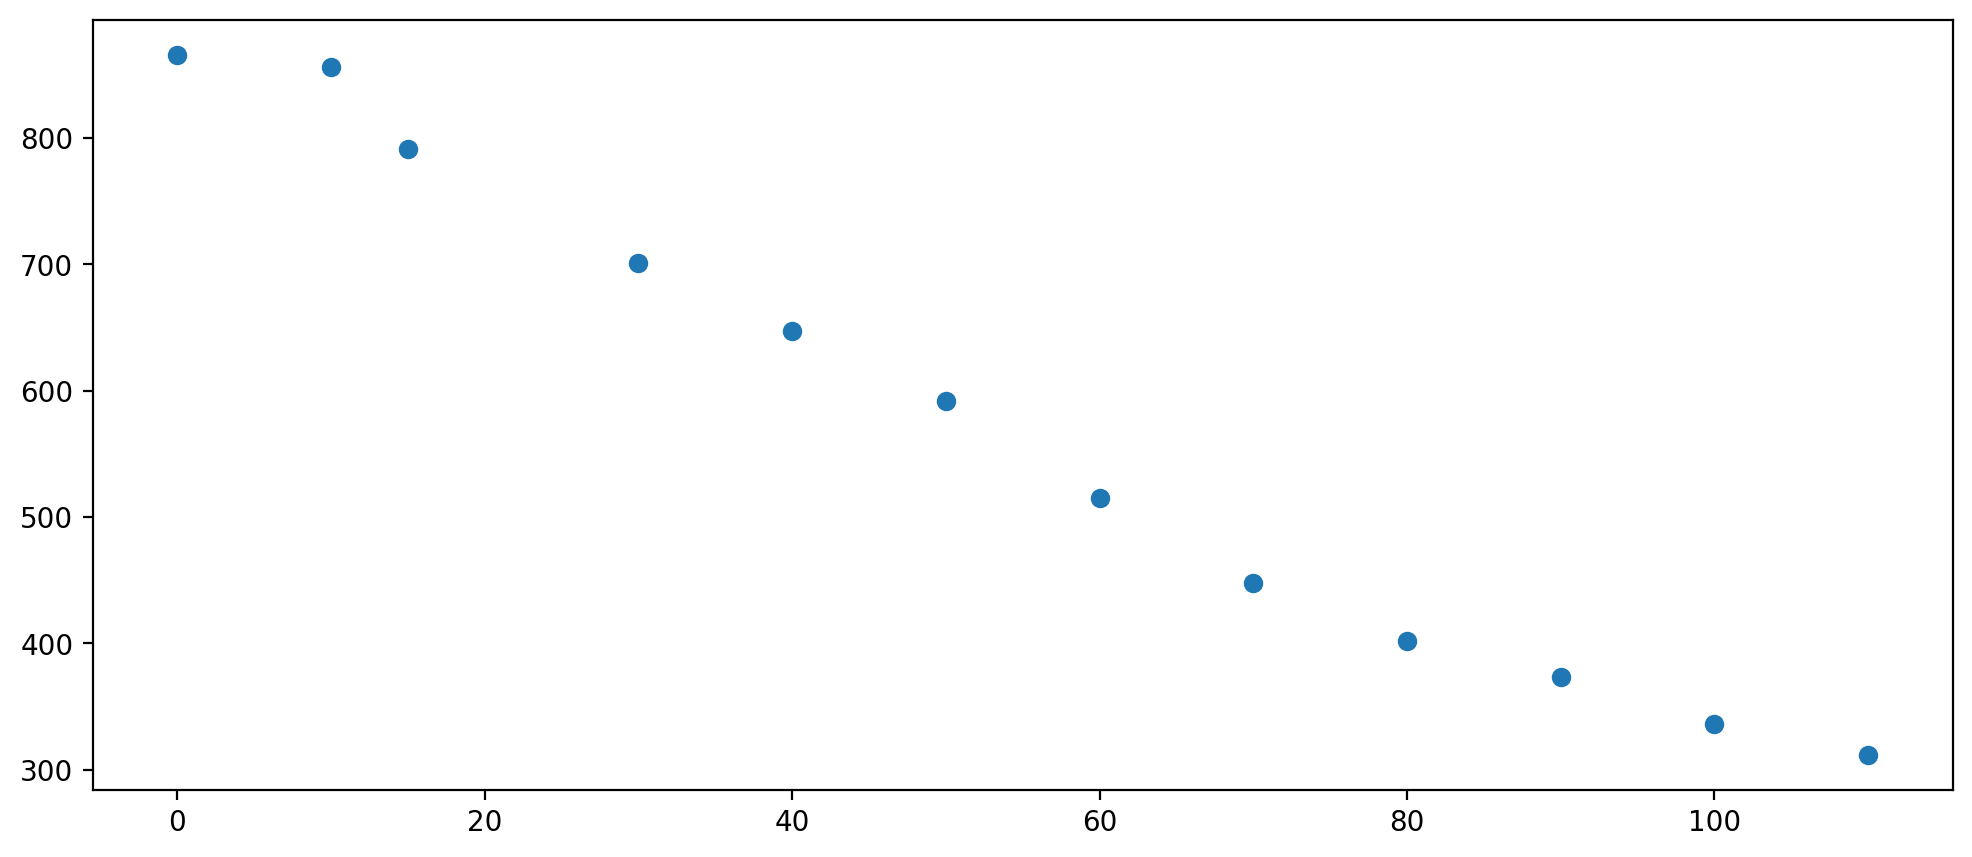

In [245]:
plt.figure(figsize = (12, 5), dpi = 200)

theta_line = np.linspace(0, 90, 1000)
param, _ = curve_fit(interpolation_func, data['theta'], data['N'])
# plt.plot(theta_line, interpolation_func(theta_line, *param))
plt.scatter(data['theta'], data['N'])

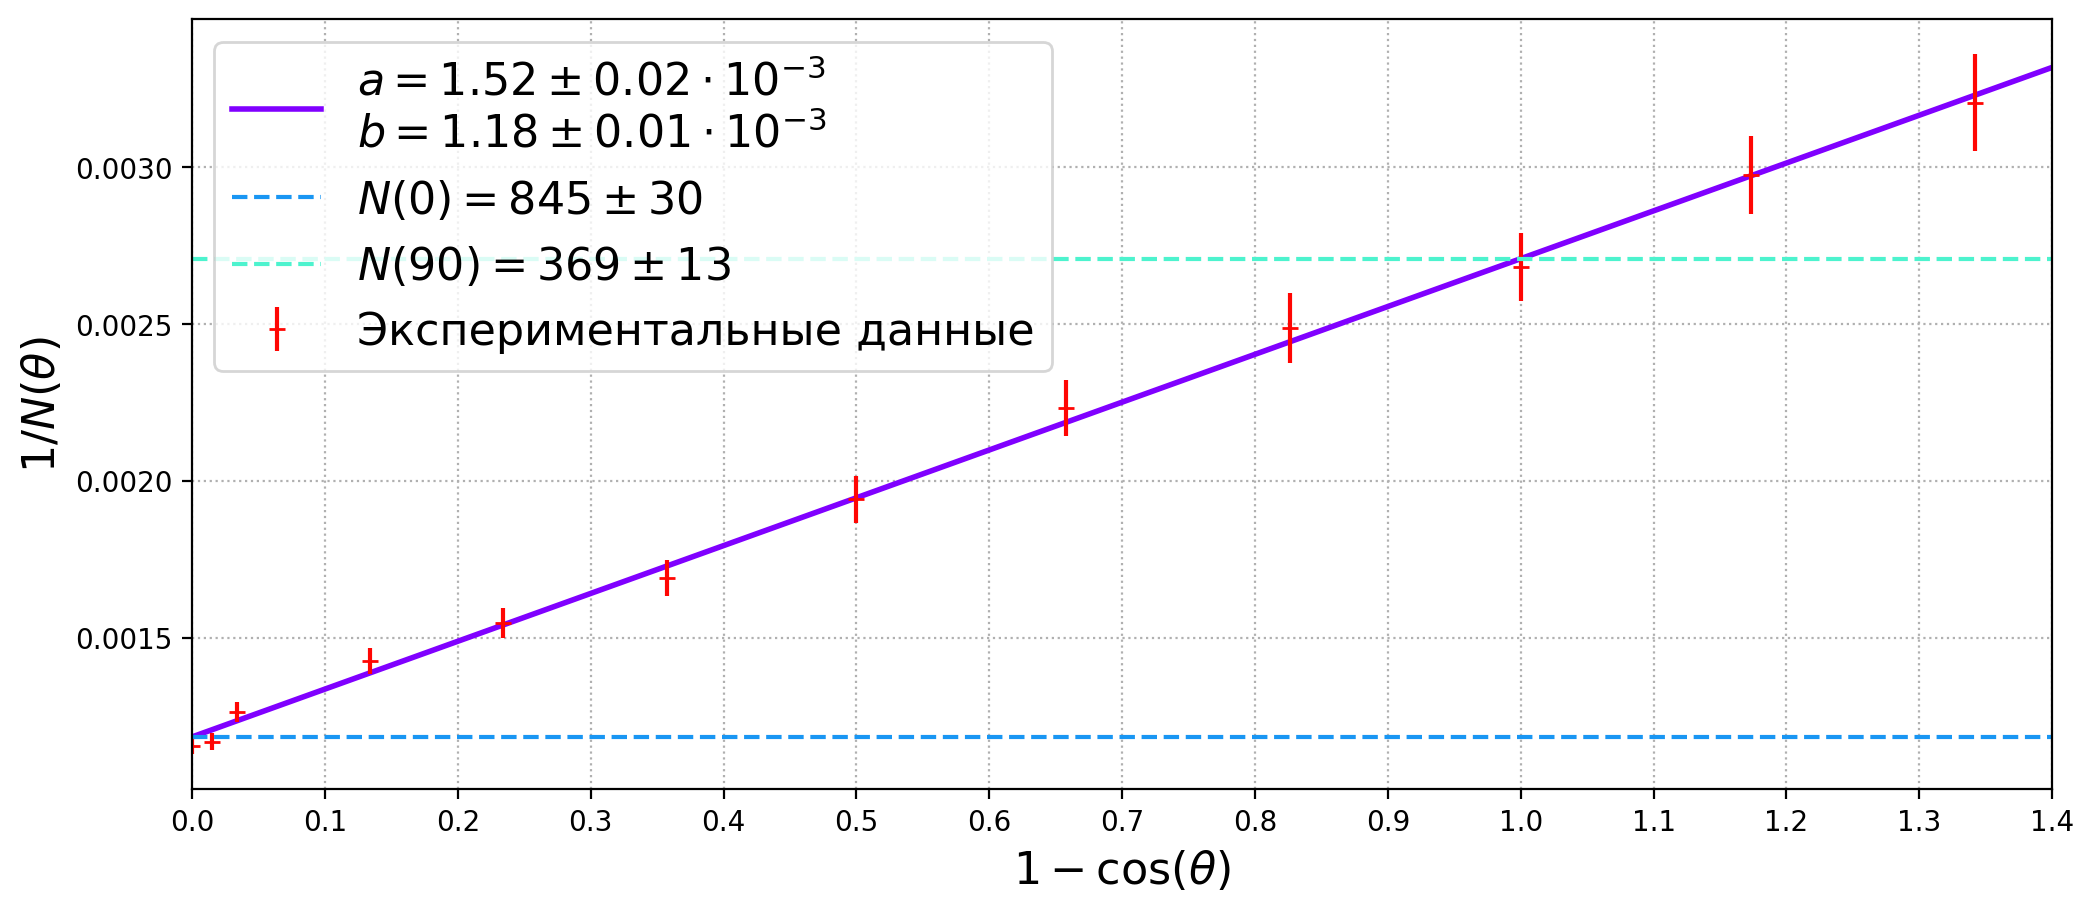

In [246]:
plt.figure(figsize = (12, 5), dpi = 200)
colorpallete = cm.rainbow

MNK = sts.linregress(1 - np.cos(data['theta'] * np.pi / 180), 1 / data['N'])
x_line = np.linspace(0, 1.4, 1000)
y_line = MNK.slope * x_line + MNK.intercept
N_zero_minus1 = MNK.intercept
N_zero = 1 / N_zero_minus1
N_90_minus1 = MNK.slope + MNK.intercept
N_90 = 1 / N_90_minus1

plt.plot(x_line, 
         y_line, 
         label = f'$a = {MNK.slope * 1e3:.2f} \pm {MNK.stderr * 1e3:.2f}' + '\cdot 10^{-3}$' + f'\n$b = {MNK.intercept * 1e3:.2f} \pm {MNK.intercept_stderr * 1e3:.2f}' + '\cdot 10^{-3}$',
         color = colorpallete(0),
         linewidth = 2)

plt.errorbar(1 - np.cos(data['theta'] * np.pi / 180), 
             1 / data['N'], 
             color = colorpallete(0.99),
             fmt = '_',
             yerr = data['errorN'] / np.power(data['N'], 2),
             label  = 'Экспериментальные данные')
plt.axhline(N_zero_minus1, color = colorpallete(0.2), linestyle = '--', label = f'$N(0) = {N_zero:.0f} \pm {0.036 * N_zero:.0f}$')
plt.axhline(N_90_minus1, color = colorpallete(0.4), linestyle = '--', label = f'$N(90) = {N_90:.0f} \pm {0.034 * N_90:.0f}$')

plt.legend(fontsize = 16)

plt.xlabel(r"$1 - \operatorname{cos}(\theta)$", fontsize = 16)
plt.ylabel(r"$1 / N(\theta)$", fontsize = 16)
plt.xticks(np.arange(0, 1.6, 0.1))
plt.xlim(0, 1.4)
plt.grid(ls = ':')

In [247]:
E_gamma = 662 #кэв
E_e = E_gamma * N_90 / (N_zero - N_90)
print(f"Энергия покоя электрона {E_e / 1e3} МэВ")

Энергия покоя электрона 0.5142323150262788 МэВ


### Обработка оцифрованных изображений графиков

In [248]:
theta_values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

print(len(theta_values))

12


In [249]:
def sum_of_two_gaussians(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    return A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2)) + A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2)) + C


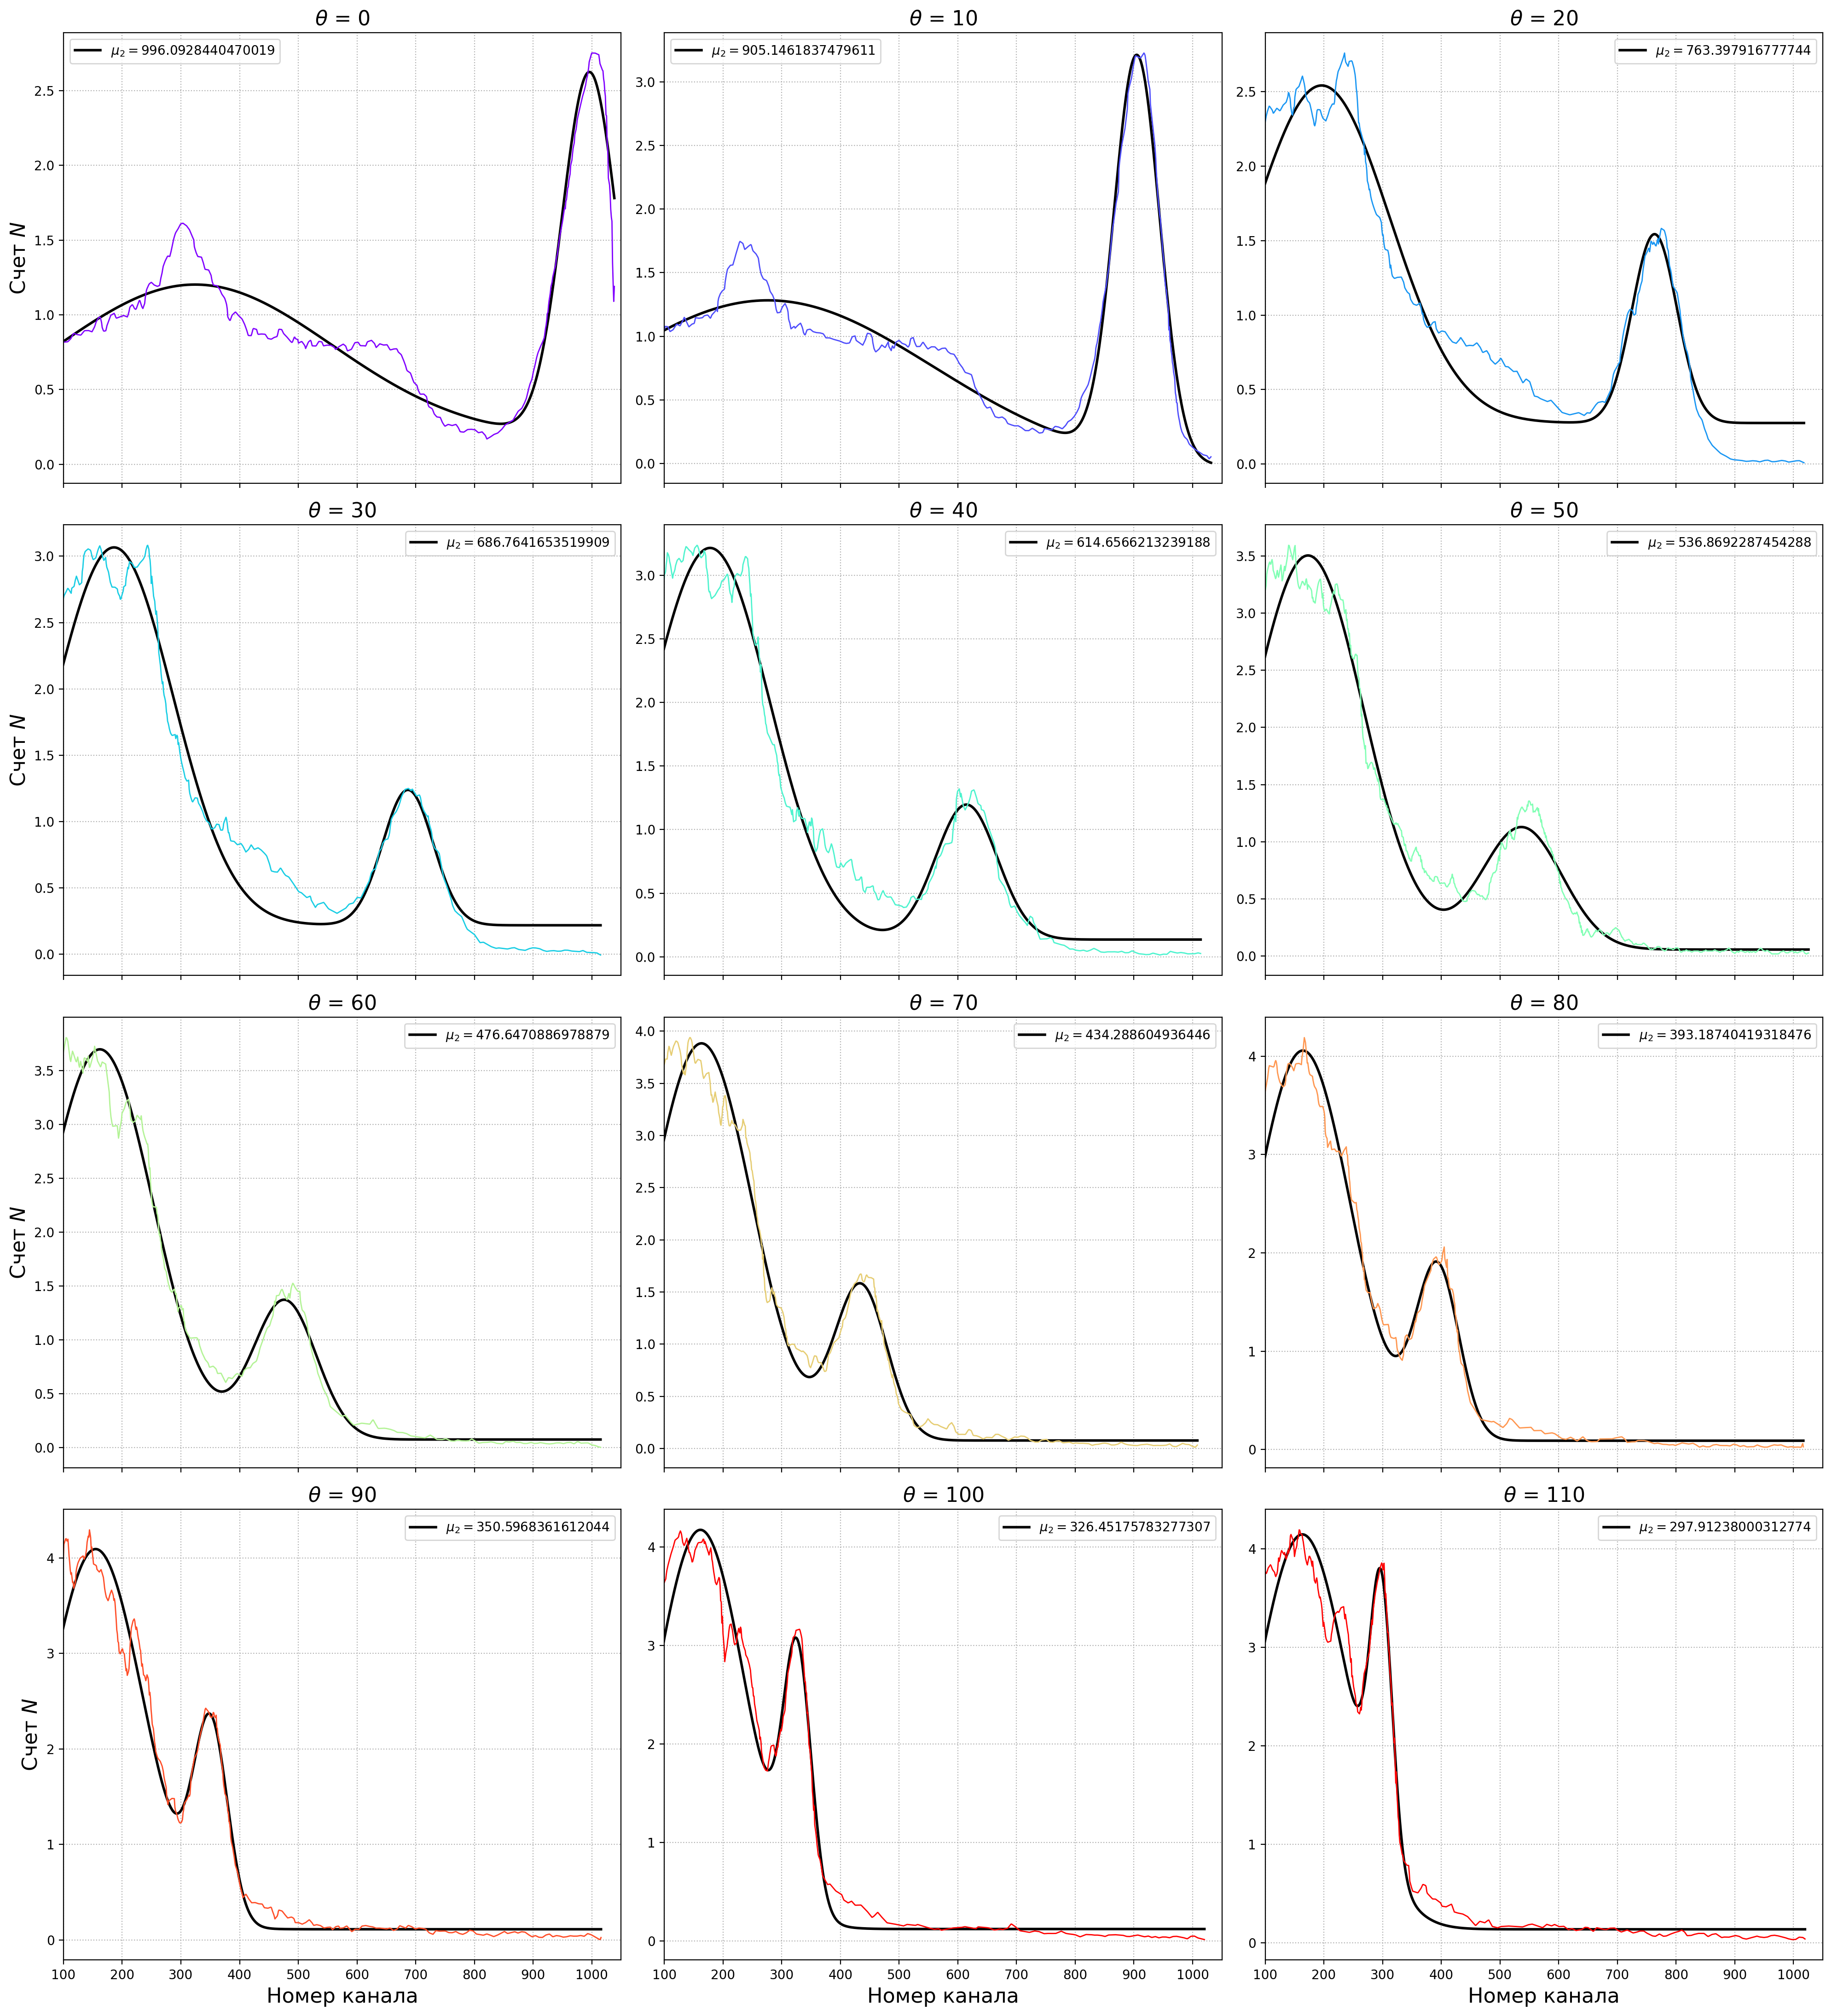

In [259]:
fig, ax = plt.subplots(4, 3, figsize = (20, 22), dpi = 200, sharex = True)
N_vals = []
error_N = []
for ind, theta in enumerate(theta_values):
    plotable = ax[ind // 3][ind % 3]
    data = pd.read_csv(f"theta_{theta}.csv")
    data = data[data.x > 20]
    # data = data.drop_duplicates(keep = False)
    x_line = np.linspace(np.min(data.x), np.max(data.x), 1000)
    y_line = interp1d(data.x, data.y, kind = 'linear')(x_line)
    peak_indecies, _ = signal.find_peaks(y_line, width = 30, height = 1)
    initial_guess = [4.0, x_line[peak_indecies[0]], 300, 4, x_line[peak_indecies[-1]], 2, 0.4]
    param, pcov = curve_fit(sum_of_two_gaussians, x_line, y_line, p0 = initial_guess, maxfev = int(1e6))
    N_vals.append(max(param[1], param[4]))
    error_N.append(np.diag(pcov)[4])
    plotable.plot(x_line, sum_of_two_gaussians(x_line, *param), color = 'black', linewidth = 2, label = f'$\mu_2 = {N_vals[-1]:.2f}$')
    plotable.plot(x_line, y_line, color = colorpallete(ind / 10), linewidth = 1)
    plotable.set_title(r"$\theta$ = " + str(theta), fontsize = 16)
    plotable.set_xticks(np.arange(0, 1200, 100))
    plotable.set_xlim(100, 1050)
    plotable.grid(ls = ':')
    plotable.legend(fontsize = 16)
    if not ind % 3: plotable.set_ylabel("Счет $N$", fontsize = 16)
    if ind in [9, 10, 11]: plotable.set_xlabel("Номер канала", fontsize = 16)
fig.tight_layout()

In [251]:
print(N_vals)

[996.0928440470019, 905.1461837479611, 763.397916777744, 686.7641653519909, 614.6566213239188, 536.8692287454288, 476.6470886978879, 434.288604936446, 393.18740419318476, 350.5968361612044, 326.45175783277307, 297.91238000312774]


In [252]:
theta_values = np.array(theta_values)
N_vals = np.array(N_vals)
error_N = np.power(np.array(error_N), 2)

In [253]:
print(error_N)

[0.21929274 0.01577875 1.55664002 5.90279373 5.69918248 7.85521503
 2.60380649 0.92956262 0.23427284 0.13608048 0.03112452 0.01582172]


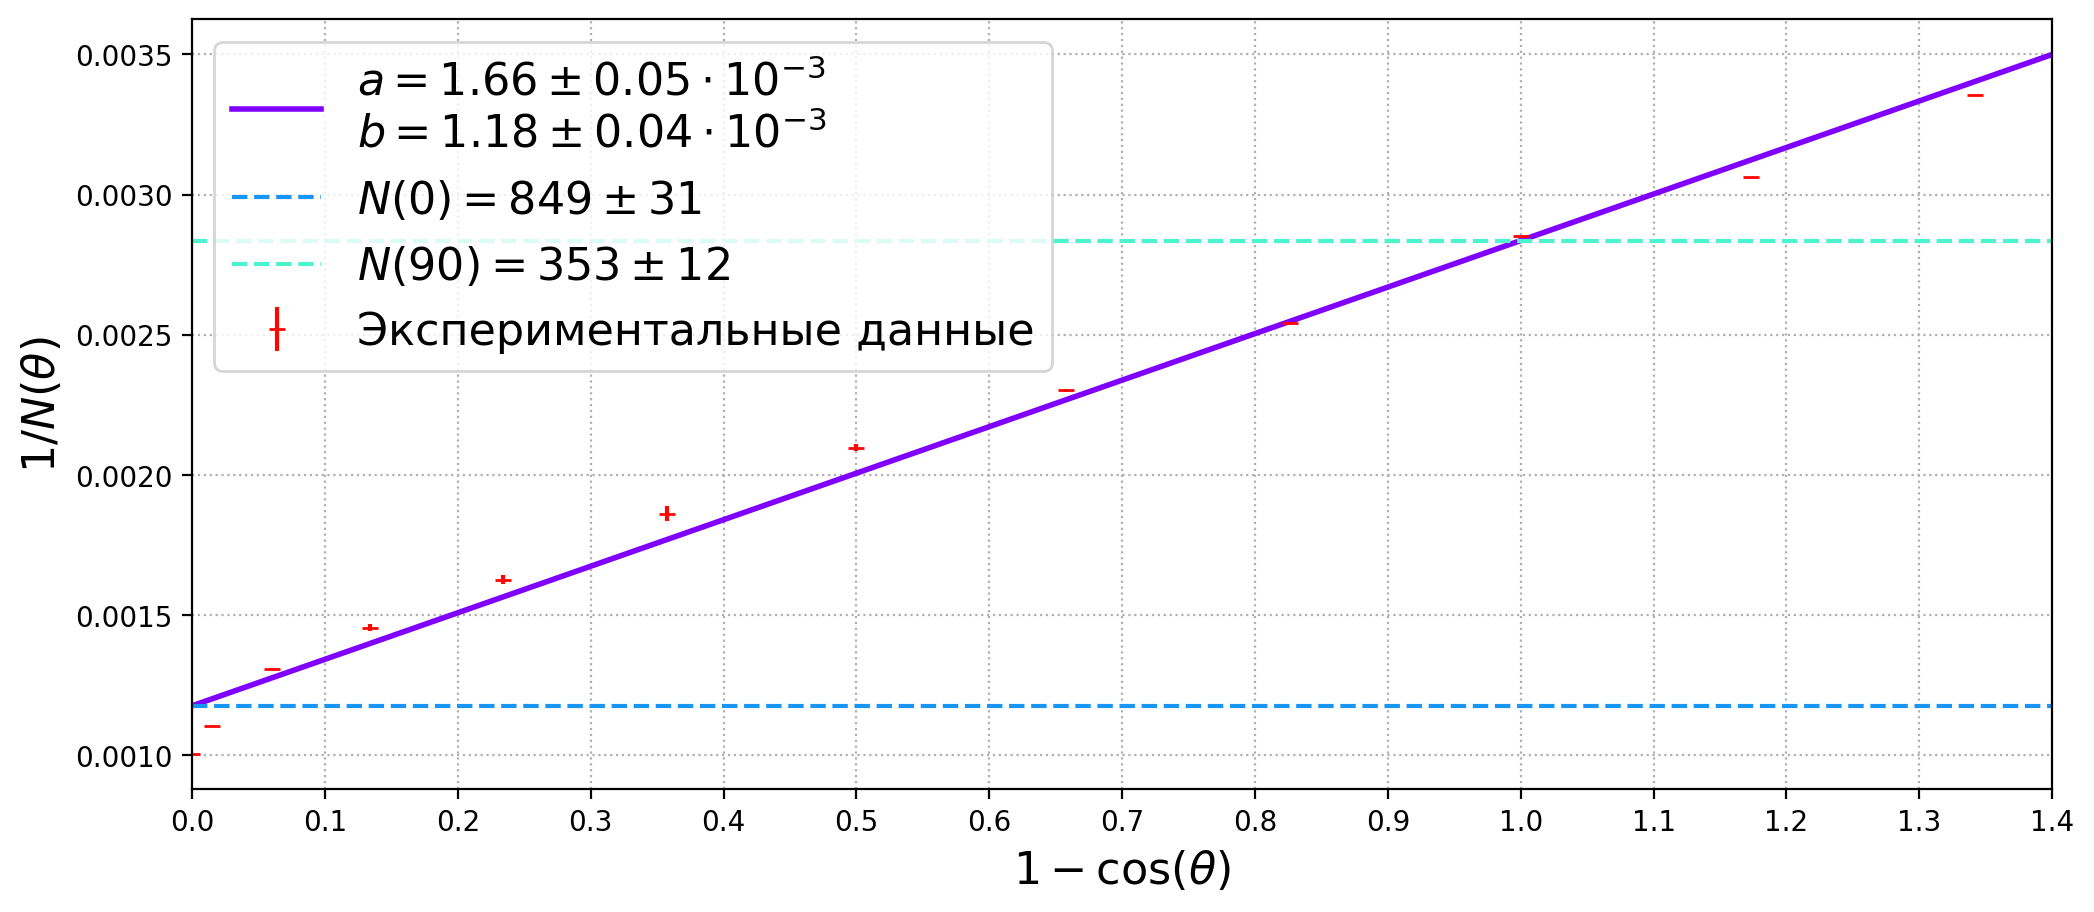

In [254]:
plt.figure(figsize = (12, 5), dpi = 200)
colorpallete = cm.rainbow

MNK = sts.linregress(1 - np.cos(theta_values * np.pi / 180), 1 / N_vals)
x_line = np.linspace(0, 1.4, 1000)
y_line = MNK.slope * x_line + MNK.intercept
N_zero_minus1 = MNK.intercept
N_zero = 1 / N_zero_minus1
N_90_minus1 = MNK.slope + MNK.intercept
N_90 = 1 / N_90_minus1

plt.plot(x_line, 
         y_line, 
         label = f'$a = {MNK.slope * 1e3:.2f} \pm {MNK.stderr * 1e3:.2f}' + '\cdot 10^{-3}$' + f'\n$b = {MNK.intercept * 1e3:.2f} \pm {MNK.intercept_stderr * 1e3:.2f}' + '\cdot 10^{-3}$',
         color = colorpallete(0),
         linewidth = 2)

plt.errorbar(1 - np.cos(theta_values * np.pi / 180), 
             1 / N_vals, 
             color = colorpallete(0.99),
             fmt = '_',
             yerr = error_N / np.power(N_vals, 2),
             label  = 'Экспериментальные данные')
plt.axhline(N_zero_minus1, color = colorpallete(0.2), linestyle = '--', label = f'$N(0) = {N_zero:.0f} \pm {0.036 * N_zero:.0f}$')
plt.axhline(N_90_minus1, color = colorpallete(0.4), linestyle = '--', label = f'$N(90) = {N_90:.0f} \pm {0.034 * N_90:.0f}$')

plt.legend(fontsize = 16)

plt.xlabel(r"$1 - \operatorname{cos}(\theta)$", fontsize = 16)
plt.ylabel(r"$1 / N(\theta)$", fontsize = 16)
plt.xticks(np.arange(0, 1.6, 0.1))
plt.xlim(0, 1.4)
plt.grid(ls = ':')

In [255]:
E_gamma = 662 #кэв
E_e = E_gamma * N_90 / (N_zero - N_90)
print(f"Энергия покоя электрона {E_e / 1e3} МэВ")

Энергия покоя электрона 0.469712561039803 МэВ


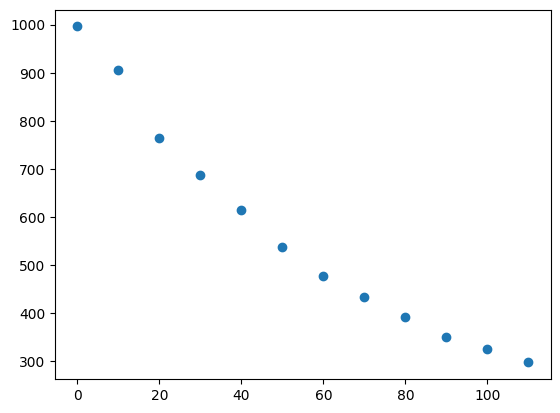

In [256]:
plt.scatter(theta_values, N_vals)